## **Modelo CNN Simple - ResNet18 + Dropout + Soft Attention Espacial** 

In [1]:
import io
import torch
import os
import pandas as pd
import seaborn as sns
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import subprocess
from tqdm import tqdm
from datetime import datetime
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torchsummary import summary
from PIL import Image
from tensorboard.backend.event_processing import event_accumulator
%matplotlib inline

## Definición de transformación de los datos de entrada

In [2]:
class MinMaxNormalize(object):
    """Transformación para normalizar imágenes con Min-Max por canal a rango [0, 1], trabajando con tensores."""
    
    def __call__(self, image):
        # Convertir la imagen de PIL a tensor
        image_tensor = transforms.ToTensor()(image)  # Esto convierte la imagen a tensor en rango [0, 1]
        
        # Calcular el valor mínimo y máximo por canal en el tensor
        min_val, _ = image_tensor.view(3, -1).min(dim=1, keepdim=True)  # Calcula el mínimo por canal
        max_val, _ = image_tensor.view(3, -1).max(dim=1, keepdim=True)  # Calcula el máximo por canal
        
        # Expande las dimensiones de min_val y max_val para que coincidan con las dimensiones de la imagen
        min_val = min_val.view(3, 1, 1)  # Cambiar a forma (C, 1, 1)
        max_val = max_val.view(3, 1, 1)  # Cambiar a forma (C, 1, 1)
        
        # Normalización Min-Max por canal: (pixel - min) / (max - min)
        norm_img = (image_tensor - min_val) / (max_val - min_val + 1e-7)  # Evitar división por cero
        
        return norm_img  # Devuelve el tensor normalizado

In [23]:
class MinMaxNormalize(object):
    """Transformación para normalizar imágenes con Min-Max a rango [0, 1]."""
    def __call__(self, image):
        image = transforms.ToTensor()(image)  # Convertir a tensor primero
        # Normalización Min-Max: (pixel - min) / (max - min)
        return (image - image.min()) / (image.max() - image.min() + 1e-7)

In [6]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # Recorte aleatorio con zoom entre 80%-100%
    transforms.RandomHorizontalFlip(p=0.5),  # Voltea horizontalmente con 50% de probabilidad
    transforms.RandomRotation(15),  # Rotación aleatoria hasta 15 grados
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Ajuste aleatorio de color
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Pequeños desplazamientos aleatorios
    transforms.Resize((128, 128)),  # Redimensionar después de las transformaciones
    MinMaxNormalize(),
    
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Solo redimensionar en validación (sin data augmentation)
    MinMaxNormalize(),
    
])


## Definición del dataset

In [7]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (str): Ruta al archivo CSV con las imágenes y sus etiquetas.
            img_dir (str): Ruta al directorio que contiene las imágenes.
            transform (callable, optional): Transformaciones que se aplican a las imágenes.
        """
        self.img_labels = pd.read_csv(csv_file)  # Leer el archivo CSV con las etiquetas
        self.img_dir = img_dir  # Ruta donde están las imágenes
        self.transform = transform  # Transformaciones a aplicar

        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.img_labels['diagnosis'].unique())}
    def __len__(self):
        """Retorna el número total de imágenes en el dataset"""
        return len(self.img_labels)

    def __getitem__(self, idx):
        """Obtiene una imagen y su etiqueta"""
        img_name = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])  # Nombre de la imagen
        image = Image.open(img_name)  # Abrir la imagen
        label = self.class_to_idx[self.img_labels.iloc[idx, 3]] # Etiqueta asociada

        if self.transform:
            image = self.transform(image)  # Aplicar transformaciones si es necesario

        return image, label

## Rutas de archivos

In [8]:


csvRoute="./content/GPTeam-DeepLearning/Dataset/bcn_20k_train.csv"
imagesFolderRoute = "/teamspace/uploads"
trainDataJsonRoute = "./content/GPTeam-DeepLearning/Dataset/data_train_resnet18_softAtt.json"
validationDataJsonRoute= "./content/GPTeam-DeepLearning/Dataset/data_val_resnet18_softAtt.json"
filteredCsvRoute = "./content/GPTeam-DeepLearning/Dataset/bcn_20k_train_filtrado.csv"
logsRoute = "./runs"
savedParametersRoute = "./saved_models_parameters/Parameters"
savedModelsRoute = "./saved_models_parameters/Models"
savedResultsRoute = "./results"

## Generación del dataset de entrenamiento y validación

***Carga del dataframe***

In [9]:
df = pd.read_csv(csvRoute)
df.head()

,bcn_filename,age_approx,anatom_site_general,diagnosis,lesion_id,capture_date,sex,split
0,BCN_0000000001.jpg,55.0,anterior torso,MEL,BCN_0003884,2012-05-16,male,train
1,BCN_0000000003.jpg,50.0,anterior torso,MEL,BCN_0000019,2015-07-09,female,train
2,BCN_0000000004.jpg,85.0,head/neck,SCC,BCN_0003499,2015-11-23,male,train
3,BCN_0000000006.jpg,60.0,anterior torso,NV,BCN_0003316,2015-06-16,male,train
4,BCN_0000000010.jpg,30.0,anterior torso,BCC,BCN_0004874,2014-02-18,female,train


***Exclusión de clases menos representativas***

In [18]:
df_original = df.copy()
#Definir las clases que deseas excluir por su nombre
clases_a_excluir = ['SCC', 'DF', 'VASC']  # Sustituye estos nombres por las clases que quieres excluir

# Filtrar el DataFrame para excluir las clases especificadas
df_filtrado = df[~df['diagnosis'].isin(clases_a_excluir)]

df_filtrado.to_csv(filteredCsvRoute, index=False)

df = df_filtrado.copy()
df_filtrado['diagnosis'].unique()

array(['MEL', 'NV', 'BCC', 'BKL', 'AK'], dtype=object)

***Busqueda de spliteo adecuado (sin lesson_id iguales para dataset de entrenamiento y validación)***

In [19]:
# Obtener los valores únicos de lesion_id
unique_lesions = df['lesion_id'].unique()

# Búsqueda del mejor split
best_train, best_test = None, None
target_ratio = 0.8 * len(df)

for seed in range(1000):  # Exploramos diferentes random_state
    train_ids, test_ids = train_test_split(unique_lesions, test_size=0.2, random_state=seed)

    x_train = df[df['lesion_id'].isin(train_ids)]
    x_test = df[df['lesion_id'].isin(test_ids)]

    # Verificar que la cantidad de filas sea la correcta Y que los lesion_id no se repitan
    if abs(len(x_train) - target_ratio) < 1 and set(x_train['lesion_id']).isdisjoint(set(x_test['lesion_id'])):
        best_train, best_test = x_train, x_test
        print(f"Random state encontrado: {seed}")
        break

# Si no se encontró un split válido, lanzar error
if best_train is None or best_test is None:
    raise ValueError("No se encontró un split válido después de 1000 intentos")

# Asignar los mejores valores encontrados
train_df, val_df = best_train, best_test

assert set(train_df['lesion_id']).isdisjoint(set(val_df['lesion_id'])), "Error: Hay lesion_id repetidos entre train_df y val_df"

Random state encontrado: 25


In [20]:
# VERIFICACION ADICIONAL DE NO REPETICION DE LESSIONID EN AMBOS DATASETS
for idtrain in train_df['lesion_id'].unique():
    for idval in val_df['lesion_id'].unique():
        if idtrain.strip() == idval.strip():
            print("Coincidence found")

In [21]:
# Verificación de la carga de todos los arhivos
archivos_en_directorio = []
# Recorrer todos los archivos en el directorio
for archivo in os.listdir(imagesFolderRoute):
    if os.path.isfile(os.path.join(imagesFolderRoute, archivo)):
        archivos_en_directorio.append(archivo)

# La columna del DataFrame con los nombres de los archivos
column_files = df['bcn_filename']
# Convertir las listas a conjuntos para realizar la diferencia
set_column_files = set(column_files)
set_archivos_en_drive = set(archivos_en_directorio)
valores_faltantes = set_column_files - set_archivos_en_drive

print(f"Cantidad de imagenes faltantes: {len(valores_faltantes)}")

Cantidad de imagenes faltantes: 0


## **Guardado de los datasets divididos inicialmente**

**Guardado de data de dataframes de entrenamiento y validación**

In [22]:
train_df.to_json(trainDataJsonRoute, orient='records', lines=True)
val_df.to_json(validationDataJsonRoute, orient='records', lines=True)

**Definición del Modelo**

In [16]:
# Mecanismo de Soft-Attention Espacial
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.conv_attention = nn.Sequential(
            nn.Conv2d(in_channels, 1, kernel_size=1),  # Mapa de atención 1x1
            nn.Softmax(dim=2)                           # Normalización espacial
        )
        
    def forward(self, x):
        # x: (batch, 512, H, W) [Ej: (batch, 512, 7, 7)]
        # Generar mapa de atención (batch, 1, H, W)
        attn_weights = self.conv_attention(x)
        # Aplicar atención: características * pesos
        attended_features = x * attn_weights  # Broadcasting automático
        
        return attended_features


# Modelo ResNet18 con Dropout + Soft-Attention
class ResNet18WithAttention(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18WithAttention, self).__init__()
        # 1. Cargar ResNet18 preentrenado
        self.resnet18 = models.resnet18(pretrained=True)
        
        # 2. Congelar capas convolucionales
        for param in self.resnet18.parameters():
            param.requires_grad = False

        # 2.1 Descongelar la ultima capa
        for param in self.resnet18.layer4.parameters():
            param.requires_grad = True

        # 2.1 Descongelar la ultima capa
        for param in self.resnet18.layer3.parameters():
            param.requires_grad = True
        
        # 3. Añadir mecanismo de atención espacial
        self.attention = SpatialAttention(in_channels=512)  # ResNet18 tiene 512 canales al final
        
        # 4. Modificar capas FC con Dropout
        self.resnet18.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Extraer características hasta la última capa convolucional
        x = self.resnet18.conv1(x)
        x = self.resnet18.bn1(x)
        x = self.resnet18.relu(x)
        x = self.resnet18.maxpool(x)
        x = self.resnet18.layer1(x)
        x = self.resnet18.layer2(x)
        x = self.resnet18.layer3(x)
        x = self.resnet18.layer4(x)  # Salida: (batch, 512, 7, 7)
        
        # Aplicar atención espacial
        x = self.attention(x)  # (batch, 512, 7, 7) con pesos aprendidos
        
        # Global Average Pooling y clasificación
        x = self.resnet18.avgpool(x)  # (batch, 512, 1, 1)
        x = torch.flatten(x, 1)       # (batch, 512)
        x = self.resnet18.fc(x)       # (batch, num_classes)
        
        return x

In [10]:
import torch
import torch.nn as nn
import torchvision.models as models

# Mecanismo de Soft-Attention Espacial
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.conv_attention = nn.Sequential(
            nn.Conv2d(in_channels, 1, kernel_size=1),  # Mapa de atención 1x1
            nn.Softmax(dim=2)                           # Normalización espacial
        )
        
    def forward(self, x):
        # x: (batch, 512, H, W) [Ej: (batch, 512, 7, 7)]
        # Generar mapa de atención (batch, 1, H, W)
        attn_weights = self.conv_attention(x)
        # Aplicar atención: características * pesos
        attended_features = x * attn_weights  # Broadcasting automático
        
        return attended_features


# Modelo ResNet34 con Dropout + Soft-Attention
class ResNet34WithAttention(nn.Module):
    def __init__(self, num_classes):
        super(ResNet34WithAttention, self).__init__()
        # 1. Cargar ResNet34 preentrenado
        self.resnet34 = models.resnet34(pretrained=True)
        
        # 2. Congelar capas convolucionales
        for param in self.resnet34.parameters():
            param.requires_grad = False

        # 2.1 Descongelar la última capa (layer4)
        for param in self.resnet34.layer4.parameters():
            param.requires_grad = True

        # 2.1 Descongelar la penúltima capa (layer3)
        for param in self.resnet34.layer3.parameters():
            param.requires_grad = True
        
        # 3. Añadir mecanismo de atención espacial
        self.attention = SpatialAttention(in_channels=512)  # ResNet34 tiene 512 canales al final
        
        # 4. Modificar capas FC con Dropout
        self.resnet34.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Extraer características hasta la última capa convolucional
        x = self.resnet34.conv1(x)
        x = self.resnet34.bn1(x)
        x = self.resnet34.relu(x)
        x = self.resnet34.maxpool(x)
        x = self.resnet34.layer1(x)
        x = self.resnet34.layer2(x)
        x = self.resnet34.layer3(x)
        x = self.resnet34.layer4(x)  # Salida: (batch, 512, 7, 7)
        
        # Aplicar atención espacial
        x = self.attention(x)  # (batch, 512, 7, 7) con pesos aprendidos
        
        # Global Average Pooling y clasificación
        x = self.resnet34.avgpool(x)  # (batch, 512, 1, 1)
        x = torch.flatten(x, 1)       # (batch, 512)
        x = self.resnet34.fc(x)       # (batch, num_classes)
        
        return x

# Visualización de la ejecución del modelo

Ejecutar desde cmd lo siguiente para ver desde el navegador el menú de tensorboard: tensorboard --logdir=runs

Ejecucion en navegador

In [11]:
def run_tensorboard(logdir="runs", port=6006):
    try:
        process = subprocess.Popen(
            ["tensorboard", f"--logdir={logdir}", f"--port={port}"],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE
        )
        print(f"TensorBoard ejecutándose en http://localhost:{port}")
        return process
    except Exception as e:
        print(f"Error al iniciar TensorBoard: {e}")

# Ejecutar TensorBoard
tb_process = run_tensorboard()

TensorBoard ejecutándose en http://localhost:6006


Ejecucion en notebook

In [13]:
%reload_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6007 (pid 4205), started 0:00:02 ago. (Use '!kill 4205' to kill it.)

## **Entrenamiento y validación del modelo**

**Definición de gráficas adicionales a emplear**

In [14]:
# Función para registrar el heatmap (matriz de confusión)
def log_heatmap(writer, epoch, ground_truth, predictions, labels):
    # Calcula la matriz de confusión usando el orden de las etiquetas
    cm = confusion_matrix(ground_truth, predictions, labels=range(len(labels)))
    
    # Crear la figura
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Groundtruth")
    ax.set_title("Matriz de Confusión")
    
    # Registrar la figura en TensorBoard
    writer.add_figure("Heatmap", fig, global_step=epoch)
    plt.close(fig)

# Función para registrar la grilla 2x2 de TP, FP, TN, FN (para clasificación binaria)
def log_values_predicted(writer, epoch, ground_truth, predictions):
    # Calcular la matriz de confusión
    cm = confusion_matrix(ground_truth, predictions, labels=[0, 1])
    
    # Crear anotaciones combinando etiqueta y valor
    annot = np.array([
        [f"TN\n{cm[0,0]}", f"FP\n{cm[0,1]}"],
        [f"FN\n{cm[1,0]}", f"TP\n{cm[1,1]}"]
    ])
    
    # Crear el heatmap
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=annot, fmt="", cmap="Blues",
                xticklabels=["False", "True"],
                yticklabels=["False", "True"],
                cbar=True, ax=ax)
    ax.set_xlabel("Eje Predicho (False/True)")
    ax.set_ylabel("Eje Verdadero (False/True)")
    ax.set_title("Predicción de valores")
    
    # Registrar la figura en TensorBoard
    writer.add_figure("Predicción de valores", fig, global_step=epoch)
    plt.close(fig)

**Seteo del dispositivo a usar**

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(F"Dispositivo utilizado: {device} ({torch.cuda.get_device_name()})")
else:
    print(F"Dispositivo utilizado: {device}")

Dispositivo utilizado: cuda (Tesla T4)


**Especificación de parámetros**

In [16]:
learning_rate = 0.0001
num_classes = 5
num_epochs = 50
batch_size = 32

**Ejecución del modelo**

In [25]:
# Crear el dataset de entrenamiento y validación
train_dataset = CustomDataset(csv_file=filteredCsvRoute, img_dir=imagesFolderRoute, transform=train_transform)
val_dataset = CustomDataset(csv_file=filteredCsvRoute, img_dir=imagesFolderRoute, transform=val_transform)

# Actualizar los datasets con los subconjuntos correspondientes
train_dataset.img_labels = train_df
val_dataset.img_labels = val_df

# Inicialización de tensorboard
executionModelDateTime = datetime.now().strftime("Ejecucion %d-%m-%Y %H-%M")
writer = SummaryWriter(log_dir=os.path.join(logsRoute,executionModelDateTime))

# Crear los DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Definición de la cantidad de clases, la función de perdida, el optimizador y el learning rate estático
modelAt = ResNet34WithAttention(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(modelAt.parameters(), lr=learning_rate, momentum=0.9,weight_decay=1e-3)
optimizer = optim.Adam(modelAt.parameters(), lr=learning_rate, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
model = modelAt.to(device)
executionStatistics_list = []

for epoch in range(num_epochs):
    model.train()  # Modo entrenamiento
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    # Entrenamiento
    for inputs, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=True):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Estadísticas de la pérdida
        running_loss += loss.item()
        # Precisión
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    #print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_dataloader)}, Accuracy: {100 * correct_preds / total_preds}%")
    train_loss = running_loss / len(train_dataloader)
    train_accuracy = 100 * correct_preds / total_preds

    # Validación
    model.eval()  # Modo evaluación
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_groundtruth = []
    all_predictions = []

    with torch.no_grad():  # No calcular gradientes durante la validación
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()  # Usamos correct_val en lugar de correct_preds
            total_val += labels.size(0)  # Usamos total_val en lugar de total_preds

            all_groundtruth.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    val_loss = running_val_loss/len(val_dataloader)
    val_accuracy = 100 * correct_val / total_val
    
    # Ajustar la tasa de aprendizaje si la pérdida de validación no mejora
    scheduler.step(val_loss)
    
    # Agregar valores a TensorBoard
    writer.add_scalar("Loss/Train", train_loss, epoch)
    writer.add_scalar("Loss/Validation", val_loss, epoch)
    writer.add_scalar("Accuracy/Train", train_accuracy, epoch)
    writer.add_scalar("Accuracy/Validation", val_accuracy, epoch)

    # Obtener los nombres de las clases (suponiendo que están en df_filtrados.columns)
    labels_names = list(df_filtrado['diagnosis'].unique())
    # Registrar el heatmap y la grilla de valores en TensorBoard
    log_heatmap(writer, epoch, all_groundtruth, all_predictions, labels_names)
    log_values_predicted(writer, epoch, all_groundtruth, all_predictions)
    
    # Carga de hiperparametros y metricas
    execution_statistics = {
        "epoch": epoch,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "num_epochs": num_epochs,
        "Train Loss": train_loss,
        "Validation Loss": val_loss,
        "Train Accuracy": train_accuracy,
        "Validation Accuracy": val_accuracy
        
    }
    
    executionStatistics_list.append(execution_statistics)
    
    # Gráfica de loss y accuracy por cada epoca
    writer.add_scalars("Loss", {"Train": train_loss, "Validation": val_loss}, epoch)
    writer.add_scalars("Accuracy", {"Train": train_accuracy, "Validation": val_accuracy}, epoch)
    
    
    print(f"Epoch {epoch+1}/{num_epochs} FINISHED => "
        f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
        f"Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")
    


writer.flush()
writer.close()

# Guardado de estadisticas de ejecucion
df_statistics = pd.DataFrame.from_dict(executionStatistics_list)
df_statistics.to_excel(os.path.join(savedResultsRoute, f"{executionModelDateTime}_results.xlsx"), index=False)
# Guardado del modelo completo
torch.save(model, os.path.join(savedModelsRoute, f"{executionModelDateTime}_modelo_entrenado_resnet18_softAtt_ka_completo.pth"))
# Guardado de los pesos del modelo
torch.save(model.state_dict(), os.path.join(savedParametersRoute, f"{executionModelDateTime}_modelo_entrenado_resnet18_softAtt_ka_pesos.pth"))


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/50 - Training:   0%|          | 0/294 [00:00<?, ?it/s]

Epoch 1/50 - Training: 100%|██████████| 294/294 [23:59<00:00,  4.90s/it]


Epoch 1/50 FINISHED => Train Loss: 1.0841, Val Loss: 1.0941, Train Acc: 58.31%, Val Acc: 58.55%


Epoch 2/50 - Training: 100%|██████████| 294/294 [05:43<00:00,  1.17s/it]


Epoch 2/50 FINISHED => Train Loss: 0.9094, Val Loss: 0.9744, Train Acc: 65.27%, Val Acc: 63.19%


Epoch 3/50 - Training: 100%|██████████| 294/294 [05:41<00:00,  1.16s/it]


Epoch 3/50 FINISHED => Train Loss: 0.8186, Val Loss: 0.9488, Train Acc: 69.45%, Val Acc: 65.79%


Epoch 4/50 - Training: 100%|██████████| 294/294 [05:37<00:00,  1.15s/it]


Epoch 4/50 FINISHED => Train Loss: 0.7602, Val Loss: 1.0462, Train Acc: 71.31%, Val Acc: 61.36%


Epoch 5/50 - Training: 100%|██████████| 294/294 [05:46<00:00,  1.18s/it]


Epoch 5/50 FINISHED => Train Loss: 0.7172, Val Loss: 1.0235, Train Acc: 73.39%, Val Acc: 62.51%


Epoch 6/50 - Training: 100%|██████████| 294/294 [05:44<00:00,  1.17s/it]


Epoch 6/50 FINISHED => Train Loss: 0.6578, Val Loss: 1.1207, Train Acc: 75.52%, Val Acc: 60.60%


Epoch 7/50 - Training: 100%|██████████| 294/294 [06:07<00:00,  1.25s/it]


Epoch 7/50 FINISHED => Train Loss: 0.6224, Val Loss: 1.0521, Train Acc: 77.28%, Val Acc: 63.28%


Epoch 8/50 - Training: 100%|██████████| 294/294 [05:37<00:00,  1.15s/it]


Epoch 8/50 FINISHED => Train Loss: 0.5153, Val Loss: 1.1238, Train Acc: 80.98%, Val Acc: 61.32%


Epoch 9/50 - Training: 100%|██████████| 294/294 [05:39<00:00,  1.15s/it]


Epoch 9/50 FINISHED => Train Loss: 0.4523, Val Loss: 1.0886, Train Acc: 83.91%, Val Acc: 63.83%


Epoch 10/50 - Training: 100%|██████████| 294/294 [05:37<00:00,  1.15s/it]


Epoch 10/50 FINISHED => Train Loss: 0.4287, Val Loss: 1.1871, Train Acc: 84.79%, Val Acc: 60.72%


Epoch 11/50 - Training: 100%|██████████| 294/294 [05:31<00:00,  1.13s/it]


Epoch 11/50 FINISHED => Train Loss: 0.3812, Val Loss: 1.2435, Train Acc: 86.11%, Val Acc: 59.02%


Epoch 12/50 - Training: 100%|██████████| 294/294 [05:49<00:00,  1.19s/it]


Epoch 12/50 FINISHED => Train Loss: 0.3237, Val Loss: 1.2660, Train Acc: 88.65%, Val Acc: 60.51%


Epoch 13/50 - Training: 100%|██████████| 294/294 [05:40<00:00,  1.16s/it]


Epoch 13/50 FINISHED => Train Loss: 0.2774, Val Loss: 1.2784, Train Acc: 90.37%, Val Acc: 61.53%


Epoch 14/50 - Training: 100%|██████████| 294/294 [05:41<00:00,  1.16s/it]


Epoch 14/50 FINISHED => Train Loss: 0.2655, Val Loss: 1.3140, Train Acc: 90.73%, Val Acc: 59.79%


Epoch 15/50 - Training: 100%|██████████| 294/294 [05:43<00:00,  1.17s/it]


Epoch 15/50 FINISHED => Train Loss: 0.2438, Val Loss: 1.3144, Train Acc: 91.50%, Val Acc: 61.91%


Epoch 16/50 - Training: 100%|██████████| 294/294 [05:43<00:00,  1.17s/it]


Epoch 16/50 FINISHED => Train Loss: 0.2106, Val Loss: 1.3317, Train Acc: 92.82%, Val Acc: 61.32%


Epoch 17/50 - Training: 100%|██████████| 294/294 [05:42<00:00,  1.16s/it]


Epoch 17/50 FINISHED => Train Loss: 0.1863, Val Loss: 1.3401, Train Acc: 93.67%, Val Acc: 62.85%


Epoch 18/50 - Training: 100%|██████████| 294/294 [05:40<00:00,  1.16s/it]


Epoch 18/50 FINISHED => Train Loss: 0.1848, Val Loss: 1.3800, Train Acc: 93.76%, Val Acc: 61.62%


Epoch 19/50 - Training: 100%|██████████| 294/294 [05:43<00:00,  1.17s/it]


Epoch 19/50 FINISHED => Train Loss: 0.1736, Val Loss: 1.3653, Train Acc: 94.20%, Val Acc: 62.04%


Epoch 20/50 - Training: 100%|██████████| 294/294 [05:43<00:00,  1.17s/it]


Epoch 20/50 FINISHED => Train Loss: 0.1519, Val Loss: 1.3695, Train Acc: 94.83%, Val Acc: 61.96%


Epoch 21/50 - Training: 100%|██████████| 294/294 [05:37<00:00,  1.15s/it]


Epoch 21/50 FINISHED => Train Loss: 0.1550, Val Loss: 1.3312, Train Acc: 94.87%, Val Acc: 62.68%


Epoch 22/50 - Training: 100%|██████████| 294/294 [05:41<00:00,  1.16s/it]


Epoch 22/50 FINISHED => Train Loss: 0.1411, Val Loss: 1.3660, Train Acc: 95.33%, Val Acc: 61.70%


Epoch 23/50 - Training: 100%|██████████| 294/294 [05:39<00:00,  1.16s/it]


Epoch 23/50 FINISHED => Train Loss: 0.1324, Val Loss: 1.3826, Train Acc: 95.68%, Val Acc: 61.45%


Epoch 24/50 - Training: 100%|██████████| 294/294 [05:46<00:00,  1.18s/it]


Epoch 24/50 FINISHED => Train Loss: 0.1303, Val Loss: 1.3773, Train Acc: 95.75%, Val Acc: 61.15%


Epoch 25/50 - Training: 100%|██████████| 294/294 [05:40<00:00,  1.16s/it]


Epoch 25/50 FINISHED => Train Loss: 0.1272, Val Loss: 1.3810, Train Acc: 95.70%, Val Acc: 61.57%


Epoch 26/50 - Training: 100%|██████████| 294/294 [05:41<00:00,  1.16s/it]


Epoch 26/50 FINISHED => Train Loss: 0.1283, Val Loss: 1.3937, Train Acc: 95.91%, Val Acc: 61.79%


Epoch 27/50 - Training: 100%|██████████| 294/294 [05:38<00:00,  1.15s/it]


Epoch 27/50 FINISHED => Train Loss: 0.1201, Val Loss: 1.4140, Train Acc: 96.07%, Val Acc: 61.79%


Epoch 28/50 - Training: 100%|██████████| 294/294 [05:36<00:00,  1.14s/it]


Epoch 28/50 FINISHED => Train Loss: 0.1216, Val Loss: 1.4395, Train Acc: 95.97%, Val Acc: 60.89%


Epoch 29/50 - Training: 100%|██████████| 294/294 [05:36<00:00,  1.14s/it]


Epoch 29/50 FINISHED => Train Loss: 0.1186, Val Loss: 1.3899, Train Acc: 96.19%, Val Acc: 62.30%


Epoch 30/50 - Training: 100%|██████████| 294/294 [05:43<00:00,  1.17s/it]


Epoch 30/50 FINISHED => Train Loss: 0.1058, Val Loss: 1.4110, Train Acc: 96.66%, Val Acc: 61.32%


Epoch 31/50 - Training: 100%|██████████| 294/294 [05:39<00:00,  1.16s/it]


Epoch 31/50 FINISHED => Train Loss: 0.1172, Val Loss: 1.3800, Train Acc: 95.90%, Val Acc: 62.55%


Epoch 32/50 - Training: 100%|██████████| 294/294 [05:39<00:00,  1.16s/it]


Epoch 32/50 FINISHED => Train Loss: 0.1160, Val Loss: 1.3944, Train Acc: 96.37%, Val Acc: 61.83%


Epoch 33/50 - Training: 100%|██████████| 294/294 [05:49<00:00,  1.19s/it]


Epoch 33/50 FINISHED => Train Loss: 0.1184, Val Loss: 1.3856, Train Acc: 96.15%, Val Acc: 62.43%


Epoch 34/50 - Training: 100%|██████████| 294/294 [05:38<00:00,  1.15s/it]


Epoch 34/50 FINISHED => Train Loss: 0.1115, Val Loss: 1.4047, Train Acc: 96.39%, Val Acc: 61.70%


Epoch 35/50 - Training: 100%|██████████| 294/294 [05:41<00:00,  1.16s/it]


Epoch 35/50 FINISHED => Train Loss: 0.1165, Val Loss: 1.3876, Train Acc: 96.14%, Val Acc: 61.96%


Epoch 36/50 - Training: 100%|██████████| 294/294 [05:36<00:00,  1.14s/it]


Epoch 36/50 FINISHED => Train Loss: 0.1057, Val Loss: 1.4003, Train Acc: 96.61%, Val Acc: 61.36%


Epoch 37/50 - Training: 100%|██████████| 294/294 [05:36<00:00,  1.14s/it]


Epoch 37/50 FINISHED => Train Loss: 0.1172, Val Loss: 1.4073, Train Acc: 96.21%, Val Acc: 61.66%


Epoch 38/50 - Training: 100%|██████████| 294/294 [05:43<00:00,  1.17s/it]


Epoch 38/50 FINISHED => Train Loss: 0.1084, Val Loss: 1.3861, Train Acc: 96.49%, Val Acc: 62.13%


Epoch 39/50 - Training: 100%|██████████| 294/294 [05:45<00:00,  1.18s/it]


Epoch 39/50 FINISHED => Train Loss: 0.1080, Val Loss: 1.3973, Train Acc: 96.46%, Val Acc: 62.00%


Epoch 40/50 - Training: 100%|██████████| 294/294 [05:41<00:00,  1.16s/it]


Epoch 40/50 FINISHED => Train Loss: 0.1078, Val Loss: 1.4054, Train Acc: 96.54%, Val Acc: 62.89%


Epoch 41/50 - Training: 100%|██████████| 294/294 [05:46<00:00,  1.18s/it]


Epoch 41/50 FINISHED => Train Loss: 0.1056, Val Loss: 1.4117, Train Acc: 96.57%, Val Acc: 61.40%


Epoch 42/50 - Training:   1%|          | 3/294 [00:03<05:02,  1.04s/it]

## Visualización de arquitectura del modelo y gráficas de métricas

Arquitectura del modelo

In [193]:
summary(modelAt, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

Métricas del modelo

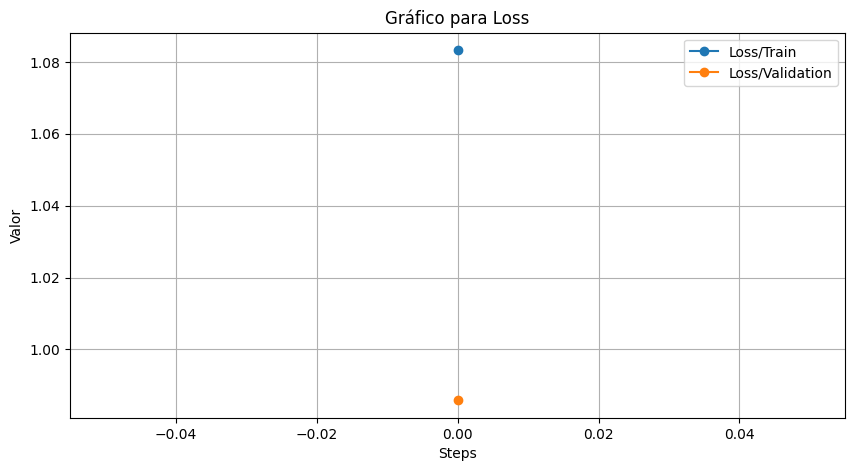

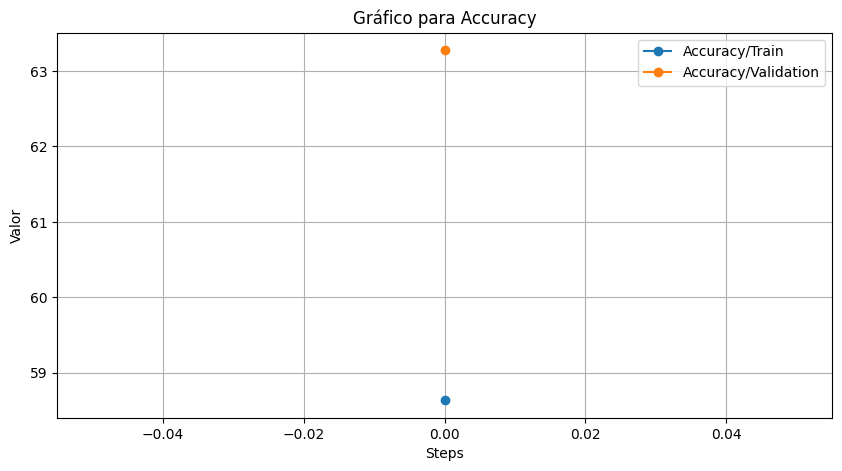

Tags de imágenes disponibles: ['Heatmap', 'Predicción de valores']


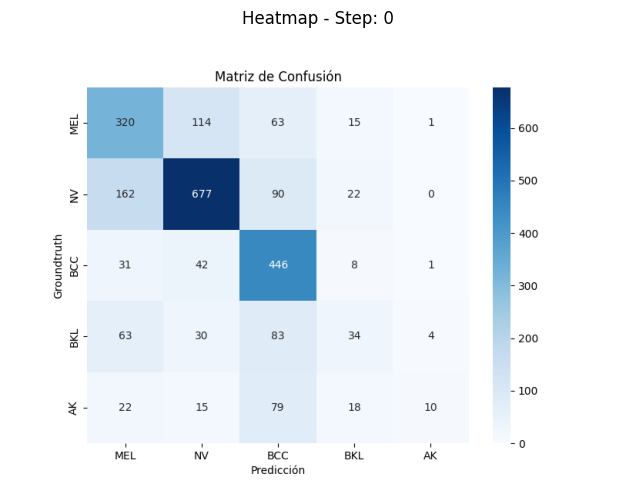

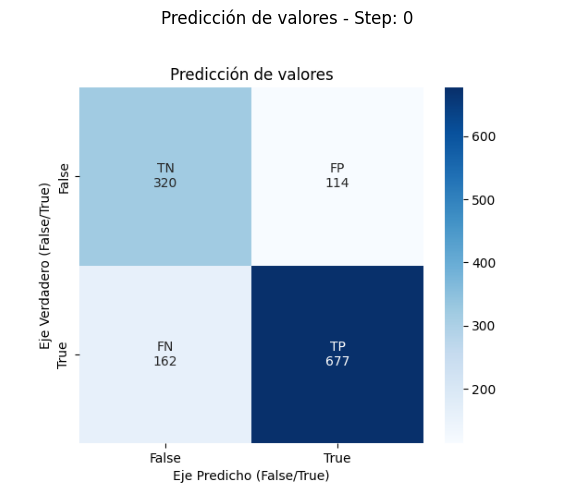

In [194]:
log_dir = os.path.join(logsRoute,executionModelDateTime)

# Crea el acumulador de eventos para leer los datos
ea = event_accumulator.EventAccumulator(log_dir)
ea.Reload()

# Primero: mostrar los gráficos de scalars agrupados (como lo hacías antes)
scalar_tags = ea.Tags().get('scalars', [])
grouped_tags = {}
for tag in scalar_tags:
    group = tag.split('/')[0] if '/' in tag else tag
    grouped_tags.setdefault(group, []).append(tag)

for group, tags in grouped_tags.items():
    plt.figure(figsize=(10, 5))
    for tag in tags:
        events = ea.Scalars(tag)
        steps = [e.step for e in events]
        values = [e.value for e in events]
        plt.plot(steps, values, marker='o', label=tag)
    plt.title(f"Gráfico para {group}")
    plt.xlabel("Steps")
    plt.ylabel("Valor")
    plt.legend()
    plt.grid(True)
    plt.show()

# Ahora: extraer y mostrar las imágenes (los gráficos registrados como imágenes)
if 'images' in ea.Tags():
    image_tags = ea.Tags()['images']
    print("Tags de imágenes disponibles:", image_tags)
    for tag in image_tags:
        events = ea.Images(tag)
        # Puedes optar por mostrar todos los eventos o, por ejemplo, solo el último.
        for event in events:
            # Cada evento tiene el atributo 'encoded_image_string', que es el contenido de la imagen.
            image = Image.open(io.BytesIO(event.encoded_image_string))
            plt.figure(figsize=(8, 6))
            plt.imshow(image)
            plt.title(f"{tag} - Step: {event.step}")
            plt.axis("off")
            plt.show()
else:
    print("No se encontraron imágenes en los registros.")

In [195]:
# Mapeo de clases
print(train_dataset.class_to_idx)

{'MEL': 0, 'NV': 1, 'BCC': 2, 'BKL': 3, 'AK': 4}


## Carga de modelo

In [196]:
# Definir la arquitectura del modelo
class MiModelo(nn.Module):
    def __init__(self):
        super(MiModelo, self).__init__()
        self.fc = nn.Linear(10, 1)  # Ejemplo simple

    def forward(self, x):
        return self.fc(x)

# Instanciar el modelo
model = MiModelo()

# Carga de solo pesos
model = torch.load(os.path.join(savedParametersRoute, f"{executionModelDateTime}_modelo_entrenado_resnet18_softAtt_ka_pesos.pth"), weights_only=True, map_location=device)
# Carga del modelo
model = torch.load(os.path.join(savedModelsRoute, f"{executionModelDateTime}_modelo_entrenado_resnet18_softAtt_ka_completo.pth"), weights_only=False, map_location=device)

# Prueba del modelo

In [197]:
model.eval()  # Ponemos el modelo en modo de evaluación

# Paso 3: Cargar la imagen y aplicar las transformaciones
image_path = 'ka.jpg'  # Pon aquí la ruta de tu imagen
image = Image.open(image_path)  # Abrir la imagen
image_tensor = val_transform(image)  # Aplicar las transformaciones

image_tensor = image_tensor.unsqueeze(0)  # Convertirlo a un batch de tamaño 1

# Paso 5: Mover la imagen al dispositivo (GPU o CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_tensor = image_tensor.to(device)
model = model.to(device)

# Paso 6: Realizar la predicción
with torch.no_grad():  # No necesitamos gradientes para la inferencia
    output = model(image_tensor)

# Paso 7: Convertir las predicciones en probabilidades con softmax
probabilities = torch.nn.functional.softmax(output, dim=1)  # Usamos dim=1 porque tenemos un batch

# Paso 8: Obtener la clase con la mayor probabilidad
_, predicted_class = torch.max(probabilities, dim=1)

# Paso 9: Interpretar la clase predicha
# Usamos el mapeo que ya tienes de clases (el 'class_to_idx' que ya definiste en tu dataset)
predicted_idx = predicted_class.item()  # Obtenemos el índice de la clase predicha
print(predicted_idx)
# Aquí usamos el mapeo de clases que creamos antes para convertir el índice a una clase legible
predicted_class_name = [key for key, value in train_dataset.class_to_idx.items() if value == predicted_idx][0]

# Mostrar la clase predicha
print(f"Predicción: {predicted_class_name}")

3
Predicción: BKL
